# Probabilistic Programming Project 2: Bayesian Neural Networks

#### Author: Matei Bejan

## Content

#### Import necessary libraries

#### 1. BNN Two-Class Classifier

1. Building the BNN using PyMC3

2. Comparison with the classic model

#### 2. BNN Multi-Class Classifier

1. One-vs-All classifier using PyMC3

2. One-Hot Encoded Label Classifier using TensorFlow

3. Comparison with the classic model

#### 4. Bayesian Convolutional Neural Network

#### 5. Bayesian Siamese Neural Network

#### 5. Bayesian Hierarchical Neural Network

#### Conclusions

#### Further work

## Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import re
import time

import pymc3 as pm
import theano
import theano.tensor as T
from theano.tensor.nnet.nnet import softmax, relu
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import precision_recall_fscore_support as score, confusion_matrix, accuracy_score
from sklearn.datasets import make_moons

import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

tf.disable_v2_behavior()
tf.disable_eager_execution()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image

Instructions for updating:
non-resource variables are not supported in the long term


## Bayesian Neural Network Two-Class Classifier 
### Titanic

Read train and test data.

In [3]:
train = pd.read_csv('titanic/train.csv')
X_test = pd.read_csv('titanic/test.csv')
y_test = pd.read_csv('titanic/gender_submission.csv')

Created features for telling if a passenger has a cabin or not, for calculating family size and for telling if a person is travelling alone. Also did some data cleaning such as removing NaNs from the dataset.

In [4]:
PassengerId = X_test['PassengerId']

In [5]:
original_train = train.copy()

full_data = [train, X_test]

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
X_test['Has_Cabin'] = X_test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

Created a function to get title of a person and grouped all the non-common titles into a single entity. I then splitted people by the following features: sex, title, embarked, fare and age.

In [6]:
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                                 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

Removed less relevant features: **PassengerId, name, ticket, cabin, sibSp**.

In [7]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
X_test = X_test.drop(drop_elements, axis = 1)

In [8]:
X_train = train.drop(labels = ['Survived'], axis = 1)
y_train = train['Survived'].tolist()

The function below defines the Bayesian Neural Network. It has two fully-connected hidden layers with a customizable number of nodes. All weights $w_i \sim N(0, 1)$ (the bias too!) and the activation functions used for the hidden and last layers are *tanh* and *sigmoid*, respectively. The final output is computed via a Bernoulli observed variable which is being fed the result of the *sigmoid* activation.

***Note:*** This architecture will be reused in the rest of the project, thus I won't be repeat the BNN's description every time. This also stands for the training process.

In [9]:
def construct_bnn(bnn_input, 
                  bnn_output, 
                  hidden_layer1 = 16, 
                  hidden_layer2 = 8):
    
    init_1 = np.random.randn(bnn_input.shape[1], hidden_layer1).astype(theano.config.floatX)
    init_2 = np.random.randn(hidden_layer1, hidden_layer2).astype(theano.config.floatX)
    init_out = np.random.randn(hidden_layer2).astype(theano.config.floatX)

    with pm.Model() as neural_network:
        ann_input = pm.Data('bnn_input', bnn_input)
        ann_output = pm.Data('bnn_output', bnn_output)

        bias = pm.Normal('bias', 0, 1, shape = (2, ))
        
        weights_in = pm.Normal('w_in', 0, 1,
                                shape = (bnn_input.shape[1], hidden_layer1),
                                testval = init_1)

        weights_12 = pm.Normal('w_12', 0, 1,
                                shape = (hidden_layer1, hidden_layer2),
                                testval = init_2)

        weights_out = pm.Normal('w_out', 0, 1,
                                  shape = (hidden_layer2,),
                                  testval = init_out)

        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in) + bias[0])
        
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_12) + bias[1])
        
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_out))

        out = pm.Bernoulli('out',
                           act_out,
                           observed = bnn_output,
                           total_size = len(bnn_output))

    return neural_network

Build a **16-4-1** bayesian neural network, set a random seed for Theano's random number generator.

In [26]:
bayesian_neural_network = construct_bnn(X_train, y_train, 16, 4)

In [27]:
set_tt_rng(MRG_RandomStreams(42))

Fit the BNN using **variational inference** and plot ELBO loss.

In [28]:
with bayesian_neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n = 30000, method = inference)

Average Loss = 520.97: 100%|██████████| 30000/30000 [00:34<00:00, 858.32it/s] 
Finished [100%]: Average Loss = 520.92


Text(0.5, 0, 'iteration')

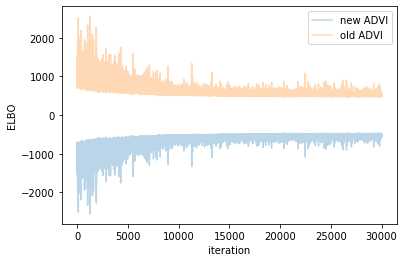

In [29]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration')

Draw samples. Then create Theano symbolic input and input size variables, as well as Theano function to compute the posterior of **X_test**.

In [30]:
trace = approx.sample(draws = 10000)

In [31]:
x = T.matrix('X')
n = T.iscalar('n')

x.tag.test_value = np.empty_like(X_test[:10])
n.tag.test_value = 100
_sample_probability_ = approx.sample_node(bayesian_neural_network.out.distribution.p,
                                          size = n,
                                          more_replacements = {bayesian_neural_network['bnn_input']: x})

sample_probability = theano.function([x, n], _sample_probability_)

/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


Get predictions, compute and print metrics and plot confusion matrix.

In [32]:
pred = sample_probability(X_test, 10000).mean(0) > 0.5

In [33]:
accuracy_bnn = (y_test['Survived'].tolist() == pred).mean() * 100

precision_bnn, recall_bnn, fscore_bnn, support_bnn = score(y_test['Survived'], pred)

In [34]:
print('Accuracy: {}'.format(accuracy_bnn))
print('Precision: {}'.format(precision_bnn))
print('Recall: {}'.format(recall_bnn))
print('F-Score: {}'.format(fscore_bnn))
print('Support: {}'.format(support_bnn))

Accuracy: 97.1291866028708
Precision: [0.98473282 0.94871795]
Recall: [0.96992481 0.97368421]
F-Score: [0.97727273 0.96103896]
Support: [266 152]


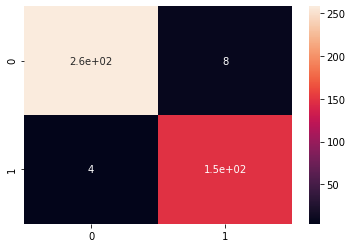

In [35]:
sns.heatmap(confusion_matrix(y_test['Survived'].tolist(), pred), annot = True)

I guess it is pretty clear that our model is all but confused when making prediction. Anyway, save results if accuracy is higher than 97%. 

In [36]:
if accuracy_bnn > 97:
    prediction_df = pd.concat([pd.DataFrame(y_test['PassengerId']), 
                        pd.DataFrame(pred, columns = ['Survived'])], 
                       axis = 1)
    prediction_df.to_csv('titanic_predicted' + str(accuracy_bnn) + '.csv', index = False)

Submitted the top 3 predictions with an accuracy score over 97% (97.6, 97.36, 97.12) and obtained a 0.7703 score on the Titanis challenge on Kaggle. Given that the 1.0 scores are cheats and most legit top scores are around 0.8, this result is pretty solid.

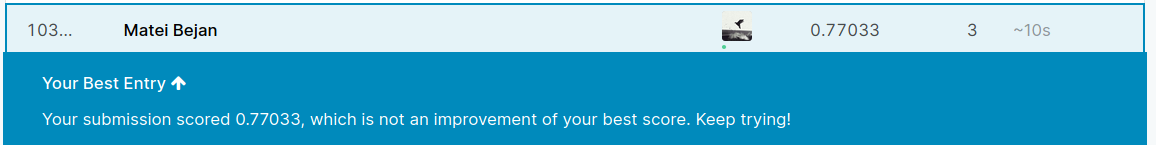

In [1]:
Image(filename='titanic_kaggle.png')

### Comparison with a classical Neural Network

I also built a classical neural network in order to create a benchmark for the BNN. The architectures are the same, the only difference being in the nature of the weghts and in that of the training process.

In [94]:
model_nn = tf.keras.models.Sequential([
    Dense(16, 
        input_dim = len(X_train.columns), 
        kernel_initializer = 'normal', 
        activation = 'tanh'),
    Dense(4, 
        kernel_initializer = 'normal', 
        activation = 'tanh'),
    Dense(1, kernel_initializer = 'normal', activation = 'sigmoid')
])

optimizer = Adam(lr = 0.0003)

model_nn.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

import os
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir) 

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/model_nn.{epoch:05d}.hdf5'
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = os.path.join('logs'),  
    write_graph = True, 
    update_freq = 'epoch'
)

In [95]:
model_nn.fit(X_train[:-150], 
             y_train[:-150],
             epochs = 50, 
             batch_size = 1, 
             initial_epoch = 0,
             callbacks = [checkpoint_callback, tensorboard_callback],
             validation_data = (X_train[-150:], y_train[-150:]))

Train on 741 samples, validate on 150 samples
Epoch 1/50
741/741 [==============================] - 3s 4ms/sample - loss: 0.6680 - acc: 0.6383 - val_loss: 0.6103 - val_acc: 0.7400
Epoch 2/50
741/741 [==============================] - 2s 3ms/sample - loss: 0.5615 - acc: 0.7692 - val_loss: 0.5102 - val_acc: 0.7800
Epoch 3/50
741/741 [==============================] - 2s 3ms/sample - loss: 0.5031 - acc: 0.7787 - val_loss: 0.4825 - val_acc: 0.7800
Epoch 4/50
741/741 [==============================] - 2s 3ms/sample - loss: 0.4845 - acc: 0.7841 - val_loss: 0.4717 - val_acc: 0.7867
Epoch 5/50
741/741 [==============================] - 3s 4ms/sample - loss: 0.4772 - acc: 0.7773 - val_loss: 0.4672 - val_acc: 0.7867
Epoch 6/50
741/741 [==============================] - 2s 3ms/sample - loss: 0.4738 - acc: 0.7814 - val_loss: 0.4640 - val_acc: 0.7733
Epoch 7/50
741/741 [==============================] - 2s 3ms/sample - loss: 0.4705 - acc: 0.7908 - val_loss: 0.4624 - val_acc: 0.7800
Epoch 8/50
741/7

In [96]:
predicted_nn = model_nn.predict(X_test)

predicted_nn = (predicted_nn > 0.5).astype(int).flatten()

In [97]:
accuracy_nn = (y_test['Survived'].tolist() == pred).mean() * 100

precision_nn, recall_nn, fscore_nn, support_nn = score(y_test['Survived'].values, predicted_nn)

In [99]:
print('Accuracy: {}'.format(accuracy_nn))
print('Precision: {}'.format(precision_nn))
print('Recall: {}'.format(recall_nn))
print('F-Score: {}'.format(fscore_nn))
print('Support: {}'.format(support_nn))

Accuracy: 95.69377990430623
Precision: [0.94252874 0.87261146]
Recall: [0.92481203 0.90131579]
F-Score: [0.93358634 0.88673139]
Support: [266 152]


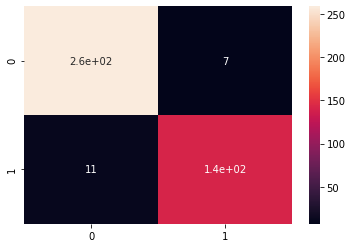

In [100]:
sns.heatmap(confusion_matrix(y_test['Survived'].tolist(), pred), annot = True)

### Final comparison

Compute a dataframe for metric comparison visualization.

The Bayesian Neural Network takes under a minute - oft as not udner 30 seconds - to train with an accuracy raging from 95% to 97%. Meanwhile, the classic model reaches an average accuracy of 95% in over one minute and a half. Even though the accuracy scores are pretty tight, there's a wide gap between the models' precision and recall scoeres, as it can be seen in the dataframe below.  

This all being said, it is clear case that the BNN yields far better results in this case given time and sample size constraints.

In [115]:
comp_df = pd.DataFrame({'Accuracy:': [accuracy_bnn, accuracy_nn], 
                        'Precision': [precision_bnn, precision_nn], 
                        'Recall': [recall_bnn, recall_nn], 
                        'F-Score': [fscore_bnn, fscore_nn], 
                        'Support': [support_bnn, support_nn]}, 
                       index = ['Bayesian NN', 'Classic NN'])

comp_df

,Accuracy:,Precision,Recall,F-Score,Support
Bayesian NN,96.650718,"[0.9772727272727273, 0.948051948051948]","[0.9699248120300752, 0.9605263157894737]","[0.9735849056603774, 0.9542483660130718]","[266, 152]"
Classic NN,95.693780,"[0.9425287356321839, 0.8726114649681529]","[0.924812030075188, 0.9013157894736842]","[0.9335863377609108, 0.8867313915857605]","[266, 152]"


## Bayesian Neural Network Multi-Class Classifier

For multi-class classificaiton I took 3 approaches:

1. One-hot-encoding classification in PyMC.
2. One-vs-all classification in PyMC.
3. One-hot-encoding classification in TensorFlow.

Out of all three, the latter yielded the best results.

### PyMC3: Multi-class classification via one-hot encoding.

Load the data, map the species to their corresponding codifications and perform a train-test split.

In [26]:
iris = pd.read_csv('iris.csv')

In [27]:
species_mapping = {'setosa': 0, 'versicolor': 1, 'virginica': 2}

iris['species'] = iris['species'].map(species_mapping)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.drop(labels = ['species'], axis = 1),
    iris['species'],
    test_size = 0.06,
    shuffle = True
)

This network uses a **softmax** activation function on the alst layer in order to get a set of probabilities - for for each species. Also, the output of the BNN is modeled via a *Categorical* distribution.

In [6]:
def construct_bnn_oh(bnn_input, 
                     bnn_output, 
                     hidden_layer1 = 16, 
                     hidden_layer2 = 8):
    
    init_1 = np.random.randn(bnn_input.shape[1], hidden_layer1).astype(theano.config.floatX)
    init_2 = np.random.randn(hidden_layer1, hidden_layer2).astype(theano.config.floatX)
    init_out = np.random.randn(hidden_layer2).astype(theano.config.floatX)

    with pm.Model() as neural_network:
        ann_input = pm.Data('bnn_input', bnn_input)
        ann_output = pm.Data('bnn_output', bnn_output)

        bias = pm.Normal('bias', 0, 1, shape = (2, ))
        
        weights_in = pm.Normal('w_in', 0, 1,
                                shape = (bnn_input.shape[1], hidden_layer1),
                                testval = init_1)

        weights_12 = pm.Normal('w_12', 0, 1,
                                shape = (hidden_layer1, hidden_layer2),
                                testval = init_2)

        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in) + bias[0])
        
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_12) + bias[1])

        act_out = softmax(act_2)

        out = pm.Categorical('out',
                             act_out,
                             observed = bnn_output,
                             total_size = len(bnn_output))
        
    return neural_network

In [30]:
bnn = construct_bnn_oh(X_train, y_train, 8, 3)

In [31]:
set_tt_rng(MRG_RandomStreams(42))

In [32]:
with bnn:
    inference = pm.ADVI()
    approx = pm.fit(n = 30000, method = inference)

Average Loss = 22,055: 100%|██████████| 30000/30000 [00:28<00:00, 1042.45it/s]
Finished [100%]: Average Loss = 22,055


Text(0.5, 0, 'iteration')

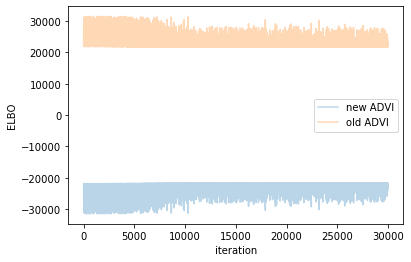

In [33]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [34]:
trace = approx.sample(draws = 15000)

In [35]:
x = T.matrix('X')
n = T.iscalar('n')

x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(bnn.out.distribution.p,
                                   size = n,
                                   more_replacements = {bnn['bnn_input']: x})

In [36]:
sample_proba = theano.function([x, n], _sample_proba)

/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


In [37]:
sample_ = sample_proba(X_test, 15000)

In [38]:
sample_.mean(0)

array([[0.33544116, 0.33188107, 0.33267778],
       [0.33574672, 0.33168097, 0.33257231],
       [0.335722  , 0.33168963, 0.33258836],
       [0.33558304, 0.33183717, 0.3325798 ],
       [0.3351836 , 0.33192353, 0.33289287],
       [0.33579472, 0.33160895, 0.33259633],
       [0.33535889, 0.33198609, 0.33265502],
       [0.33546224, 0.33186456, 0.3326732 ],
       [0.33547327, 0.33184912, 0.33267761]])

As one may observe, the one-hot encoded calssification in PyMC is yielding highly biased results - almost constant.

### PyMC3: Multi-class classification via one-vs-all classification.

I went throught the same process as before, althought this time I've repeaded the neural assembly and training process for each class.

In [2]:
iris = pd.read_csv('iris.csv')

In [3]:
species = iris['species'].unique().tolist()

species_mapping = {'setosa': {'setosa': 1, 'versicolor': 0, 'virginica': 0},
                   'versicolor': {'setosa': 0, 'versicolor': 1, 'virginica': 0},
                   'virginica': {'setosa': 0, 'versicolor': 0, 'virginica': 1}}

In [4]:
res, y_tests = [], []

In [14]:
for specie in species:
    
    iris_copy = iris.copy(deep = True)
    iris_copy['species'] = iris_copy['species'].map(species_mapping[specie])
    
    X_train, X_test, y_train, y_test = train_test_split(
        iris_copy.drop(labels = ['species'], axis = 1),
        iris_copy['species'],
        test_size = 0.06,
        shuffle = True
    )
    
    bnn = construct_bnn(X_train, y_train, 128, 64)

    set_tt_rng(MRG_RandomStreams(42))
    
    with bnn:
        inference = pm.ADVI()
        approx = pm.fit(n = 45000, method = inference)
        
    trace = approx.sample(draws = 15000)
    
    x = T.matrix('X')
    n = T.iscalar('n')

    x.tag.test_value = np.empty_like(X_train[:10])
    n.tag.test_value = 100
    _sample_proba = approx.sample_node(bnn.out.distribution.p,
                                       size = n,
                                       more_replacements = {bnn['bnn_input']: x})

    sample_proba = theano.function([x, n], _sample_proba)
    
    sample_ = sample_proba(X_test, 15000)
    
    pred = sample_.mean(0) > 0.5

    precision_bnn, recall_bnn, fscore_bnn, support_bnn = score(y_test, pred)
    
    print('Precision on predicting {}:'.format(specie), precision_bnn)
    print('Recall on predicting {}:'.format(specie), recall_bnn)
    
    res.append(pred)
    y_tests.append(y_test)

Average Loss = 301.4: 100%|██████████| 45000/45000 [06:24<00:00, 116.90it/s] 
Finished [100%]: Average Loss = 301.13
/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


Precision on predicting setosa: [1. 1.]
Recall on predicting setosa: [1. 1.]


Average Loss = 300.3: 100%|██████████| 45000/45000 [06:52<00:00, 108.99it/s]  
Finished [100%]: Average Loss = 299.83
/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision on predicting versicolor: [0.55555556 0.        ]
Recall on predicting versicolor: [1. 0.]


Average Loss = 306.24: 100%|██████████| 45000/45000 [07:39<00:00, 97.94it/s]  
Finished [100%]: Average Loss = 307.1
/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


Precision on predicting virginica: [0.55555556 0.        ]
Recall on predicting virginica: [1. 0.]


Peculiar enough, the first networks classifies *sativa* with an accuracies of 1, while the accuracy for *versicolor* and *virginica* lie between 0.3 and 0.6.

### TensorFlow: Multi-class classification by predicting the one-hot encoding of the labels.

In [118]:
iris = pd.get_dummies(iris, columns=['species'])

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.drop(labels = ['species_setosa', 'species_versicolor', 'species_virginica'], axis = 1),
    iris[['species_setosa', 'species_versicolor', 'species_virginica']],
    test_size = 0.1,
    shuffle = True
)

Iniitalize placeholders (they act kinda like Theano symbolic variables) and initial weights and bias with normally distributed data.

In [120]:
data = tf.placeholder(shape = [None, 4], dtype = tf.float32)
labels = tf.placeholder(shape = [None, 3], dtype = tf.float32)

In [121]:
hidden_layer_nodes = 8

weights_in1 = tf.Variable(tf.random_normal(shape = [4, hidden_layer_nodes]))
bias1 = tf.Variable(tf.random_normal(shape = [hidden_layer_nodes]))
weights_1out = tf.Variable(tf.random_normal(shape = [hidden_layer_nodes, 3]))
bias2 = tf.Variable(tf.random_normal(shape = [3]))

Define the actual network layers, with *ReLU* and *softmax* respectively as activation functions.

In [122]:
hidden_output = tf.nn.relu(tf.add(tf.matmul(data, weights_in1), bias1))
final_output = tf.nn.softmax(tf.add(tf.matmul(hidden_output, weights_1out), bias2))

Compute loss function and initialize optimizer.

In [123]:
loss = tf.reduce_mean(-tf.reduce_sum(labels * tf.log(final_output), axis=0))

optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001).minimize(loss)

Train the model over 10 epochs. 

In [124]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    ls = {}
    for epoch in range(1, (1000 + 1)):
        sess.run(optimizer, 
                 feed_dict = {data: X_train, 
                              labels: y_train})
        if epoch % 100 == 0:
            loss_ = sess.run(loss, 
                         feed_dict = {data: X_train, 
                                      labels: y_train})
            print('Epoch ' + str(epoch // 100) + ' - Loss:', loss_)
            ls[epoch] = loss_
            
    predicted = np.rint(sess.run(final_output, feed_dict = {data: X_test}))

Epoch 1 - Loss: 16.435196
Epoch 2 - Loss: 9.13502
Epoch 3 - Loss: 5.838211
Epoch 4 - Loss: 4.8152637
Epoch 5 - Loss: 4.258339
Epoch 6 - Loss: 3.9080048
Epoch 7 - Loss: 3.6679382
Epoch 8 - Loss: 3.49307
Epoch 9 - Loss: 3.3597927
Epoch 10 - Loss: 3.2546036


Compute and print relevant metrics.

In [134]:
accuracy_bnn = accuracy_score(y_test.to_numpy().tolist(), predicted)

precision_bnn, recall_bnn, fscore_bnn, support_bnn = score(y_test.to_numpy().tolist(), predicted)

In [135]:
print('Accuracy: {}'.format(accuracy_bnn))
print('Precision: {}'.format(precision_bnn))
print('Recall: {}'.format(recall_bnn))
print('F-Score: {}'.format(fscore_bnn))
print('Support: {}'.format(support_bnn))

Accuracy: 1.0
Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F-Score: [1. 1. 1.]
Support: [7 3 5]


There's not much to talk about here, especially given we've worked on the Iris dataset.

### Comparison with classic Neural Network

Once again, I've built a benchmark classical NN. The architectures are the same, the only difference being in the nature of the weghts and in that of the training process.

In [145]:
model_nn2 = tf.keras.models.Sequential([
    Dense(8, 
        input_dim = len(X_train.columns), 
        kernel_initializer = 'normal', 
        activation = 'relu'),
    Dense(3, 
          kernel_initializer = 'normal', 
          activation = 'softmax')
])

optimizer = Adam(lr = 0.0003)

model_nn2.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

import os
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir) 

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/model_nn2.{epoch:05d}.hdf5'
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = os.path.join('logs'),  
    write_graph = True, 
    update_freq = 'epoch'
)

In [163]:
model_nn2.fit(X_train[:-30], 
             y_train[:-30],
             epochs = 10, 
             batch_size = 1, 
             initial_epoch = 0,
             callbacks = [checkpoint_callback, tensorboard_callback],
             validation_data = (X_train[-30:], y_train[-30:]))

Train on 105 samples, validate on 30 samples
Epoch 1/10
105/105 [==============================] - 0s 3ms/sample - loss: 0.3615 - acc: 0.9619 - val_loss: 0.3057 - val_acc: 0.9667
Epoch 2/10
105/105 [==============================] - 0s 3ms/sample - loss: 0.3562 - acc: 0.9619 - val_loss: 0.3009 - val_acc: 0.9667
Epoch 3/10
105/105 [==============================] - 0s 3ms/sample - loss: 0.3519 - acc: 0.9714 - val_loss: 0.2960 - val_acc: 0.9667
Epoch 4/10
105/105 [==============================] - 0s 5ms/sample - loss: 0.3457 - acc: 0.9714 - val_loss: 0.2930 - val_acc: 0.9667
Epoch 5/10
105/105 [==============================] - 0s 4ms/sample - loss: 0.3407 - acc: 0.9619 - val_loss: 0.2873 - val_acc: 0.9667
Epoch 6/10
105/105 [==============================] - 0s 4ms/sample - loss: 0.3357 - acc: 0.9619 - val_loss: 0.2829 - val_acc: 0.9667
Epoch 7/10
105/105 [==============================] - 0s 3ms/sample - loss: 0.3317 - acc: 0.9619 - val_loss: 0.2783 - val_acc: 0.9667
Epoch 8/10
105/10

In [165]:
pred_nn = model_nn2.predict(X_test)

predicted_nn = []

for sample in pred_nn:
    temp = [0, 0, 0]
    maxi = -1
    it, place = 0, 0
    for elem in sample:
        if elem > maxi:
            maxi= elem
            place = it
        it += 1
    temp[place] = 1
    predicted_nn.append(temp)
    
predicted_nn = np.array(predicted_nn)

In [166]:
accuracy_nn = accuracy_score(y_test.to_numpy().tolist(), predicted)

precision_nn, recall_nn, fscore_nn, support_nn = score(y_test.to_numpy().tolist(), predicted)

In [167]:
print('Accuracy: {}'.format(accuracy_nn))
print('Precision: {}'.format(precision_nn))
print('Recall: {}'.format(recall_nn))
print('F-Score: {}'.format(fscore_nn))
print('Support: {}'.format(support_nn))

Accuracy: 1.0
Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F-Score: [1. 1. 1.]
Support: [7 3 5]


### Final comparison

I decided to keep the dataframe output format out of formalism, since it is obvious that the networks have the same predictive power on Iris.

In [162]:
comp_df = pd.DataFrame({'Accuracy:': [accuracy_bnn, accuracy_nn], 
                        'Precision': [precision_bnn, precision_nn], 
                        'Recall': [recall_bnn, recall_nn], 
                        'F-Score': [fscore_bnn, fscore_nn], 
                        'Support': [support_bnn, support_nn]}, 
                       index = ['Bayesian NN', 'Classic NN'])

comp_df

,Accuracy:,Precision,Recall,F-Score,Support
Bayesian NN,1.0,"[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[7, 3, 5]"
Classic NN,1.0,"[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[7, 3, 5]"


## Bayesian Convolutional Neural Network Multi-Class Classifier
### MNIST

My choice for the BCNN modelling was TFP, mianly because PyMC3 does not offer any support on convolution and implementing these operations myself was out of the question, since time was short.

The code itself is built on the BCNN defined here: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py. Altough development started from there, the two networks are not much alike, the one presented further being a little more complex and adapted to TensorFlow2. This also stands for the training and prediction process.

In [2]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

Define an utility to compute batches in order to be fed to the convolutional network in the training process.

In [3]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

Define the placeholders just like before and construct a CNN like you'd usually do in *keras*, but this time using $\href{https://www.tensorflow.org/probability/api_docs/python/tfp/layers}{TFP \ layers}$ instead of the usual TF-keras build-up. Afterwards, build the log likelyhood, loss and accuracy functions.

In [4]:
images = tf.placeholder(tf.float32, shape = [None, 28, 28])
labels = tf.placeholder(tf.float32, [None,])
hold_prob = tf.placeholder(tf.float32)

bnn = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tfp.layers.Convolution2DFlipout(32, 
                                    kernel_size = 5,
                                    padding = "SAME",
                                    activation = tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size = [2, 2], 
                                 strides = [2, 2], 
                                 padding = "SAME"), 
    tfp.layers.Convolution2DFlipout(32, 
                                kernel_size = 5,
                                padding = "SAME",
                                activation = tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size = [2, 2], 
                                 strides = [2, 2], 
                                 padding = "SAME"), 
    tfp.layers.Convolution2DFlipout(64, 
                                    kernel_size = 5, 
                                    padding = "SAME", 
                                    activation = tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size = [2, 2], 
                                 strides = [2, 2],
                                 padding = "SAME"),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(1024,
                            activation = tf.nn.relu),
    tf.keras.layers.Dropout(hold_prob),
    tfp.layers.DenseFlipout(10)
])

logits = bnn(images)

labels_distribution = tfp.distributions.Categorical(logits = logits)

neg_log_likelihood = -tf.reduce_mean(labels_distribution.log_prob(labels))

elbo_loss = neg_log_likelihood + sum(bnn.losses) / len(X_train)

optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)

train_op = optimizer.minimize(elbo_loss)

predictions = tf.argmax(logits, axis = 1)

accuracy, accuracy_update_op = tf.metrics.accuracy(labels = labels, predictions = predictions)

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train the BCNN and print the loss and accuracy every epoch. Also print the test loss and accuracy.

In [ ]:
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    start_time = time.time()
    sess.run(init_op)
    for step in range(100001):
        images_b, labels_b = next_batch(50, X_train, y_train)
        sess.run([train_op,
                  accuracy_update_op],
                  feed_dict = {images: images_b,
                               labels: labels_b, 
                               hold_prob: 0.5})
        if (step == 0) or (step % 10000 == 0):
            loss_train, accuracy_train = sess.run([elbo_loss, accuracy], 
                                                  feed_dict = {images: images_b,
                                                               labels: labels_b, 
                                                               hold_prob: 0.5})
            print("Epoch " + str(step // 10000) + \
                  " - Loss: " + str(loss_train) + \
                  ", Accuracy: " + str(accuracy_train) + \
                  " ; elapsed: " + str(round(time.time() - start_time, 3)) + 's')
    
    images_h, labels_h = next_batch(len(X_test), X_test, y_test)
    loss_test, accuracy_test = sess.run([elbo_loss, accuracy], 
                                          feed_dict = {images: images_h,
                                                       labels: labels_h, 
                                                       hold_prob: 0.5})
    
    print('Test loss: ' + str(loss_test) + ' and test Accuracy: ' + str(accuracy_test))

Epoch 0 - Loss: 62.268322, Accuracy: 0.08 ; elapsed: 2.251s
Epoch 1 - Loss: 4.2317147, Accuracy: 0.9631237 ; elapsed: 1842.244s
Epoch 2 - Loss: 1.4768991, Accuracy: 0.9706225 ; elapsed: 3655.324s
Epoch 3 - Loss: 1.0569103, Accuracy: 0.9732382 ; elapsed: 5472.135s
Epoch 4 - Loss: 0.55578685, Accuracy: 0.97436666 ; elapsed: 7287.654s
Epoch 5 - Loss: 0.51788485, Accuracy: 0.9749977 ; elapsed: 9100.08s
Epoch 6 - Loss: 0.41408163, Accuracy: 0.9752854 ; elapsed: 10915.07s
Epoch 7 - Loss: 0.35878885, Accuracy: 0.9754892 ; elapsed: 12727.665s
Epoch 8 - Loss: 0.25944182, Accuracy: 0.9756648 ; elapsed: 14545.362s
Epoch 9 - Loss: 0.30617929, Accuracy: 0.9757954 ; elapsed: 16355.566s
Epoch 10 - Loss: 0.38779852, Accuracy: 0.9759544 ; elapsed: 18174.999s


## Bayesian Siamese Neural Network

### Titanic

#### PyMC3

This has been new territory for me and I was lucky that our lab prof. - Andrei Ilie - was kind enough to give us a brief overview regarding what a siamese network is and how it's supposed to work. Starting from his dissemination, I build up a shallow understanding of this model from the following sources:

1. $\href{https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d}{One-Shot \ Learning \ with \ Siamese \ Networks}$ (Medium web article)

2. $\href{https://becominghuman.ai/siamese-networks-algorithm-applications-and-pytorch-implementation-4ffa3304c18}{Siamese \ Networks: \ Algorithm, \ Applications \ And \ PyTorch \ Implementation}$

3. $\href{https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf}{Siamese \ Neural \ Networks \ for \ One-shot \ Image \ Recognition; \ Gregory Koch, \ Richard Zemel, \ Ruslan Salakhutdinov}$

4. $\href{https://medium.com/@prabhnoor0212/siamese-network-keras-31a3a8f37d04}{Siamese \ Network \ Keras \ for Image \ and \ Text \ Similarity}$

After reading all of these it seemed only natural to me to approach this problem from PyMC's perspective. After all, the duplicated architecture means with shared weights translated into a single set of weights which are samples and two branches of calculations.

Compared to the BNN presented at the very beginning of this project, I have made the following changes:

1. Created 5 imputs: 2 for the train samples, 2 for the train labels and 1 for the similarity. In this case, the similarity is either 1 or 0, depending on the survival of both samples.

2. I have created a $2^{nd}$ set of activations, as well as a $2^{nd}$ Bernoulli output.

3. I have taken the absolute of the difference betweent the the Bernoullis and, after applying another set of weights and a softmax actiaviton on the result, I have fed this to a third Bernoulli. This last variable represents the similarity outcome computed by the network.

Unfortunately, I have run into technical problems with Theano, namely the fact that it does not care to accept *numpy.float64* as input for its symbolic *floatX*, even though under the hood the two point to the same thing. I have decided to keep the architecture as I am pretty certain of the modelling itself. In order to somewhat prove my belief, I have modeled a mock-up instance-based BSNN in order to show that the modelling is done correctly and that the output of the last distribution is integral to what we need. ***Note:*** I say instance-based because it can only be trained.

I have defined below a couple of utility function in order to restructure the data so it can be properly fed to the model.

In [56]:
def pack_data(X_data, y_data, split1, split2):
    xt = pd.DataFrame({'Pclass1': X_data[:split1]['Pclass'].values,
                       'Sex1': X_data[:split1]['Sex'].values,
                       'Age1': X_data[:split1]['Age'].values,
                       'Parch1': X_data[:split1]['Parch'].values,
                       'Fare1': X_data[:split1]['Fare'].values,
                       'Embarked1': X_data[:split1]['Embarked'].values,
                       'Has_Cabin1': X_data[:split1]['Has_Cabin'].values,
                       'FamilySize1': X_data[:split1]['FamilySize'].values,
                       'IsAlone1': X_data[:split1]['IsAlone'].values,
                       'Title1': X_data[:split1]['Title'].values,
                       'Pclass2': X_data[split2:]['Pclass'].values,
                       'Sex2': X_data[split2:]['Sex'].values,
                       'Age2': X_data[split2:]['Age'].values,
                       'Parch2': X_data[split2:]['Parch'].values,
                       'Fare2': X_data[split2:]['Fare'].values,
                       'Embarked2': X_data[split2:]['Embarked'].values,
                       'Has_Cabin2': X_data[split2:]['Has_Cabin'].values,
                       'FamilySize2': X_data[split2:]['FamilySize'].values,
                       'IsAlone2': X_data[split2:]['IsAlone'].values,
                       'Title2': X_data[split2:]['Title'].values})
    
    yt = []
    
    for class1, class2 in zip(y_data[:split1], y_data[split2:]):
        yt.append((class1, class2, class1 == class2))
        
    return xt, yt

def unpack_data(X_packed, y_packed):
    X_unpacked1 = X_packed[[col for col in X_packed.columns if "1" in col]]
    X_unpacked2 = X_packed[[col for col in X_packed.columns if "2" in col]]
    
    y_unpacked1, y_unpacked2, similarity = [], [], []
    for tupled_row in y_packed:
        y_unpacked1.append(tupled_row[0])
        y_unpacked2.append(tupled_row[1])
        similarity.append(tupled_row[0] == tupled_row[1])
        
    return X_unpacked1, X_unpacked2, y_unpacked1, y_unpacked2, similarity

Pack the data in order to form pairs of samples.

In [57]:
X_train_packed, y_train_packed = pack_data(X_train, y_train, 445, 446)

X_test_packed, y_test_packed = pack_data(X_test, y_test, 209, 209)

Unpack data in order for it to have the proper structure for our first network.

In [58]:
x1, x2, y1, y2, s = unpack_data(X_train_packed, y_train_packed)

In [59]:
def construct_bsnn(bnn_input1,
                   bnn_input2,
                   bnn_output1,
                   bnn_output2,
                   similarity,
                   hidden_layer1 = 16, 
                   hidden_layer2 = 8):
    
    init_1 = np.random.randn(bnn_input1.shape[1], hidden_layer1).astype(theano.config.floatX)
    init_2 = np.random.randn(hidden_layer1, hidden_layer2).astype(theano.config.floatX)
    init_out = np.random.randn(hidden_layer2).astype(theano.config.floatX)

    with pm.Model() as neural_network:
        ann_input1 = pm.Data('bnn_input1', bnn_input1)
        ann_input2 = pm.Data('bnn_input2', bnn_input2)
        ann_output1 = pm.Data('bnn_output', bnn_output1)
        ann_output2 = pm.Data('bnn_output2', bnn_output2)
        ann_similarity = pm.Data('similarity', similarity)
        
        bias1 = pm.Normal('bias1', 0, 1, shape = (2, ))
        
        weights_in = pm.Normal('w_in', 0, 1,
                                shape = (bnn_input1.shape[1], hidden_layer1),
                                testval = init_1)

        weights_12 = pm.Normal('w_12', 0, 1,
                                shape = (hidden_layer1, hidden_layer2),
                                testval = init_2)
        
        weights_out = pm.Normal('w_out', 0, 1,
                                  shape = (hidden_layer2,),
                                  testval = init_out)

        act1_1 = pm.math.tanh(pm.math.dot(ann_input1,
                                         weights_in) + bias1[0])
        
        act1_2 = pm.math.tanh(pm.math.dot(act1_1,
                                         weights_12) + bias1[1])

        act1_out = pm.math.sigmoid(pm.math.dot(act1_2,
                                              weights_out))

        out1 = pm.Bernoulli('out1',
                            act1_out,
                            observed = ann_output1,
                            total_size = len(bnn_output1))
    
        bias2 = pm.Normal('bias2', 0, 1, shape = (2, ))
        
        act2_1 = pm.math.tanh(pm.math.dot(ann_input2,
                                 weights_in) + bias2[0])
        
        act2_2 = pm.math.tanh(pm.math.dot(act2_1,
                                         weights_12) + bias2[1])

        act2_out = pm.math.sigmoid(pm.math.dot(act2_2,
                                              weights_out))
        
        out2 = pm.Bernoulli('out2',
                            act2_out,
                            observed = ann_output2,
                            total_size = len(bnn_output2))

        last_layer = pm.Normal('last_layer', 0, 1, total_size = len(bnn_output2))
                                  
        act_out = pm.math.sigmoid(
            pm.math.dot(
                pm.math.abs_(out1.distribution.p - out2.distribution.p), last_layer))
        
        final_output = pm.Bernoulli('final_output', 
                                    act_out, 
                                    observed = ann_similarity, 
                                    total_size = len(bnn_output2))

    return neural_network

In [60]:
bsnn = construct_bsnn(x1, x2, y1, y2, s)

In [61]:
set_tt_rng(MRG_RandomStreams(42))

In [62]:
with bsnn:
    inference = pm.ADVI()
    approx = pm.fit(n = 30000, method = inference)

Average Loss = 3.0258: 100%|██████████| 30000/30000 [00:43<00:00, 687.64it/s]
Finished [100%]: Average Loss = 3.0249


Text(0.5, 0, 'iteration')

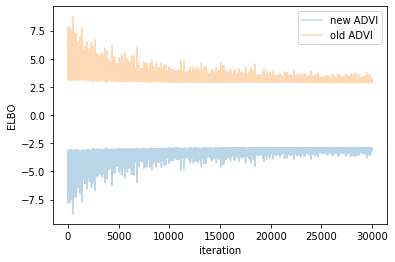

In [63]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [64]:
trace = approx.sample(draws = 15000)

In [65]:
xt1, xt2, yt1, yt2, st = unpack_data(X_test_packed, y_test_packed)

In [66]:
x_symb1 = T.matrix('X1')
x_symb2 = T.matrix('X2')
n = T.iscalar('n')
x_symb1.tag.test_value = np.empty_like(xt1[:10])
x_symb2.tag.test_value = np.empty_like(xt2[:10])
n.tag.test_value = 100

_sample_proba_nn = approx.sample_node(bsnn.final_output.distribution.p,
                                      size = n,
                                      more_replacements = {bsnn['bnn_input1']: x_symb1, 
                                                           bsnn['bnn_input2']: x_symb2})

In [67]:
sample_proba = theano.function([x_symb1, x_symb2, n], _sample_proba_nn)

/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


In [69]:
sample_input = np.empty(2, dtype = object)
sample_input[:] = [xt1.to_numpy().astype(theano.config.floatX), xt2.to_numpy().astype(theano.config.floatX)]

pred = sample_proba(sample_input, 15000)

AttributeError: Bad input argument to theano function with name "<ipython-input-67-f8b0a954c716>:1" at index 0 (0-based).  
Backtrace when that variable is created:

  File "/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3242, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-7ccabfe7d635>", line 1, in <module>
    x_symb1 = T.matrix('X1')
'float' object has no attribute 'dtype'

As outputs are either 0.5 for a survival, or below in case of death, this time we set an inclusive threshold of 0.5.

In [366]:
pred = sample_nn.mean(0) >= 0.5

In [ ]:
accuracy_nn = (y_test1['Survived'].tolist() == pred1).mean(0) * 100
precision_nn, recall_nn1, fscore_nn1, support_nn1 = score(y_test1['Survived'], pred1)

In [ ]:
print('Accuracy: {} {}'.format(accuracy_nn))
print('Precision: {} {}'.format(precision_nn))
print('Recall: {} {}'.format(recall_nn))
print('F-Score: {} {}'.format(fscore_nn))
print('Support: {} {}'.format(support_nn))

### Mock-up Instance-based BSNN

Define the mock-up BSNN contruction function. Note that it only has one input and 1 output, for each packed data strucure. The data is unpacked internally and used in the modelling process. This, however, leaves Theano in the dark about where to start the computation graph, as the shared *Data* variable is not used in neither branches' activation functions.

In [87]:
def construct_bsnn(bnn_input,
                   bnn_output,
                   hidden_layer1 = 16, 
                   hidden_layer2 = 8):
    
    bnn_input1, bnn_input2, bnn_output1, bnn_output2, similarity = unpack_data(bnn_input, bnn_output)

    init_1 = np.random.randn(bnn_input1.shape[1], hidden_layer1).astype(theano.config.floatX)
    init_2 = np.random.randn(hidden_layer1, hidden_layer2).astype(theano.config.floatX)
    init_out = np.random.randn(hidden_layer2).astype(theano.config.floatX)

    with pm.Model() as neural_network:
        nn_input = pm.Data('nn_input', bnn_input)
        nn_output = pm.Data('nn_output', bnn_output)
        
        bias1 = pm.Normal('bias1', 0, 1, shape = (2, ))
        
        weights_in = pm.Normal('w_in', 0, 1,
                                shape = (bnn_input1.shape[1], hidden_layer1),
                                testval = init_1)

        weights_12 = pm.Normal('w_12', 0, 1,
                                shape = (hidden_layer1, hidden_layer2),
                                testval = init_2)
        
        weights_out = pm.Normal('w_out', 0, 1,
                                  shape = (hidden_layer2,),
                                  testval = init_out)

        act1_1 = pm.math.tanh(pm.math.dot(bnn_input1,
                                         weights_in) + bias1[0])
        
        act1_2 = pm.math.tanh(pm.math.dot(act1_1,
                                         weights_12) + bias1[1])

        act1_out = pm.math.sigmoid(pm.math.dot(act1_2,
                                              weights_out))

        out1 = pm.Bernoulli('out1',
                            act1_out,
                            observed = bnn_output1,
                            total_size = len(bnn_output1))
    
        bias2 = pm.Normal('bias2', 0, 1, shape = (2, ))
        
        act2_1 = pm.math.tanh(pm.math.dot(bnn_input2,
                                 weights_in) + bias2[0])
        
        act2_2 = pm.math.tanh(pm.math.dot(act2_1,
                                         weights_12) + bias2[1])

        act2_out = pm.math.sigmoid(pm.math.dot(act2_2,
                                              weights_out))
        
        out2 = pm.Bernoulli('out2',
                            act2_out,
                            observed = bnn_output2,
                            total_size = len(bnn_output2))

        last_layer = pm.Normal('last_layer', 0, 1, total_size = len(similarity))
                                  
        act_out = pm.math.sigmoid(
            pm.math.dot(
                pm.math.abs_(out1 - out2), last_layer))
        
        final_output = pm.Bernoulli('final_output', 
                                    act_out, 
                                    observed = similarity, 
                                    total_size = len(similarity))
        
    return neural_network

In [88]:
bsnn = construct_bsnn(X_train_packed, y_train_packed)

In [89]:
set_tt_rng(MRG_RandomStreams(42))

In [90]:
with bsnn:
    inference = pm.ADVI()
    approx = pm.fit(n = 30000, method = inference)

Average Loss = 3.0719: 100%|██████████| 30000/30000 [00:45<00:00, 656.09it/s]
Finished [100%]: Average Loss = 3.0721


Text(0.5, 0, 'iteration')

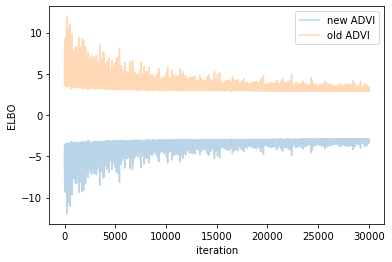

In [91]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [92]:
x = T.matrix('X')
n = T.iscalar('n')
x.tag.test_value = np.empty_like(X_test_packed[:10])
n.tag.test_value = 100

_sample_proba_nn = approx.sample_node(bsnn.final_output.distribution.p,
                                      size = n,
                                      more_replacements = {bsnn['nn_input']: x})

The `on_unused_input='ignore'` is necessary here so Theano won't throw a fit due to the fact we're not using our shared variables in its graph. 

In [93]:
sample_proba = theano.function([x, n], _sample_proba_nn, on_unused_input='ignore')

/home/matei/anaconda3/envs/progprob3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


In [94]:
pred = sample_proba(X_test_packed, 15000).mean(0)

As one may observe, the output shape matches the input shape regardless of predictin on new data. 

In [95]:
pred.shape

(445,)

In [104]:
pred_fin = [1 if p >= 0.5 else 0 for p in pred]

X_test1, X_test2, y_test1, y_test2, similarity_test = unpack_data(X_test_packed, y_test_packed)

## Bayesian Hierarchical Neural Network

### sk-learn Moons

#### PyMC3

The concept of hierarchical networks is something I've stumbled upon as I've read on different concepts for this projects.

**Disclaimer:** What you will see below is not my work, but the work of Thomas Wiecki. The code is taken form his $\href{https://twiecki.io/blog/2018/08/13/hierarchical_bayesian_neural_network/}{blog \ post}$ on the matter of Bayesian Hierarchical Neural Networks. All I wanted to do was too go through with his explanations by testing out his code. All of the comments below represent ***his insights*** on this subejct. I've copied them here - and sometimes reworded them - just so I can have a top-down continuous explanation of how this BHNN behaves.

As far as I understood, HNN's are models that perform well under the premise of nested or "hierarchical" data. Thomas' example offers helps build a bit of intuition over this subject: predicting the likelihood of a user to buy a product. There could be thousands of products but you only have a small number of measurements - purchase decisions - per item. Likely, there will be similarities between each product category, but they will all have individual differences too.

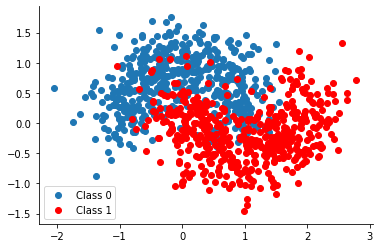

In [2]:
X, Y = make_moons(noise = 0.35, n_samples=1000)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], label = 'Class 0')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color = 'r', label = 'Class 1')
sns.despine(); 
plt.legend();

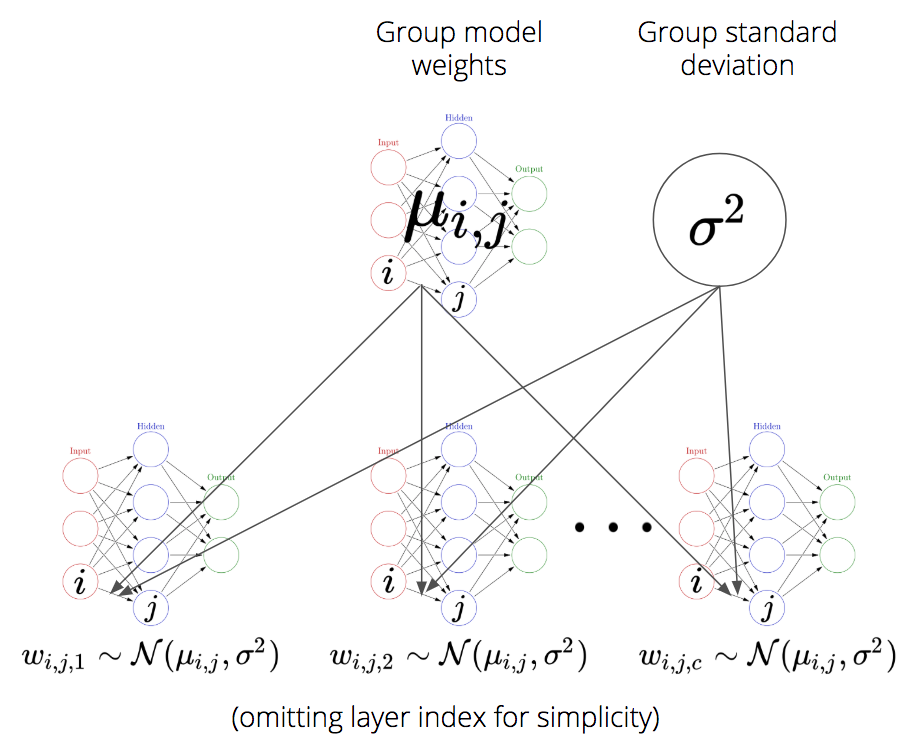

In [2]:
Image(filename='bhnn.png')

In the picture above, each individual weight has its own hierarchical structure with a single group mean parameter and 16 per-category weights distributed around the group mean. While this creates a big amount of group distributions, there is no problem with this per-se, although it might be a bit unusual. One might argue that this model is quite complex and while that's true, in terms of degrees-of-freedom, this model is simpler than the unpooled one above.

As for the code, we stack weights along a 3rd dimenson to get separate weights for each group. That way, through the power of broadcasting, the linear algebra works out almost the same as before.

In [4]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)
    
    return np.asarray(X)

In [5]:
np.random.seed(31)

n_samples = 100
n_grps = 18
n_grps_sq = int(np.sqrt(n_grps))

Xs, Ys = [], []

for i in range(n_grps):
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)
    X = pm.floatX(X)
    Y = pm.floatX(Y)
    
    rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)
    
Xs = np.stack(Xs)
Ys = np.stack(Ys)

X_train = Xs[:, :n_samples // 2, :]
y_train = Ys[:, :n_samples // 2]
X_test = Xs[:, n_samples // 2:, :]
y_test = Ys[:, n_samples // 2:]

In [6]:
def construct_bhnn(bnn_input, 
                   bnn_output, 
                   hidden_layer1 = 16, 
                   hidden_layer2 = 8):
    
    n_grps = bnn_input.shape[0]
    n_data = bnn_input.shape[2]
    
    init_1 = np.random.randn(n_data, hidden_layer1).astype(theano.config.floatX)
    init_2 = np.random.randn(hidden_layer1, hidden_layer2).astype(theano.config.floatX)
    init_out = np.random.randn(hidden_layer2).astype(theano.config.floatX)
        
    with pm.Model() as neural_network:
        ann_input = pm.Data('bnn_input', bnn_input)
        ann_output = pm.Data('bnn_output', bnn_output)
        
        # Group mean distribution for input to hidden layer
        weights_in_1_grp = pm.Normal('w_in_1_grp', 0, 1, 
                                     shape = (n_data, hidden_layer1), 
                                     testval = init_1)
        # Group standard-deviation
        weights_in_1_grp_sd = pm.HalfNormal('w_in_1_grp_sd', 1.)
        
        # Group mean distribution for weights from 1st to 2nd layer
        weights_1_2_grp = pm.Normal('w_1_2_grp', 0, 1, 
                                    shape = (hidden_layer1, hidden_layer2), 
                                    testval = init_2)
        
        weights_1_2_grp_sd = pm.HalfNormal('w_1_2_grp_sd', 1.)
        
        # Group mean distribution from hidden layer to output
        weights_2_out_grp = pm.Normal('w_2_out_grp', 0, 1, 
                                      shape = (hidden_layer2,), 
                                      testval = init_out)
        
        weights_2_out_grp_sd = pm.HalfNormal('w_2_out_grp_sd', 1.)
    
        # Separate weights for each different model, just add a 3rd dimension of weights
        weights_in_1_raw = pm.Normal('w_in_1', 
                                     shape=(n_grps, n_data, hidden_layer1))
        
        weights_in = weights_in_1_raw * weights_in_1_grp_sd + weights_in_1_grp
        
        weights_1_2_raw = pm.Normal('w_1_2', 
                                    shape=(n_grps, hidden_layer1, hidden_layer2))
        
        weights_12 = weights_1_2_raw * weights_1_2_grp_sd + weights_1_2_grp
        
        weights_2_out_raw = pm.Normal('w_2_out', 
                                      shape=(n_grps, hidden_layer2))
        
        weights_out = weights_2_out_raw * weights_2_out_grp_sd + weights_2_out_grp
        
        # Build BNN
        act_1 = pm.math.tanh(T.batched_dot(ann_input, weights_in))
        
        act_2 = pm.math.tanh(T.batched_dot(act_1, weights_12))
        
        act_out = T.batched_dot(act_2, weights_out)
        
        out = pm.Bernoulli('out', 
                           logit_p = act_out, 
                           observed = bnn_output)
        
    return neural_network

In [7]:
bhnn = construct_bhnn(X_train, y_train)

In [8]:
set_tt_rng(MRG_RandomStreams(42))

In [9]:
ahnn_input = theano.shared(X_train)
ahnn_output = theano.shared(y_train)

grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
grid = np.repeat(grid_2d[None, ...], n_grps, axis = 0)
dummy_out = np.ones((n_grps, grid.shape[1]), dtype = np.int8)

with bhnn:
    trace = pm.sample(n_init = 50000, init = 'advi+adapt_diag', tune = 10000)

    ppc_train = pm.sample_posterior_predictive(trace, samples = 1000) 
    pred_train = ppc_train['out'].mean(axis = 0) > 0.5

    ahnn_input.set_value(X_test)
    ahnn_output.set_value(y_test)

    ppc_test = pm.sample_posterior_predictive(trace, samples = 1000)
    pred_test = ppc_test['out'].mean(axis = 0) > 0.5

    ahnn_input.set_value(grid)
    ahnn_output.set_value(dummy_out)
    ppc_grid = pm.sample_posterior_predictive(trace, samples = 1000)['out']

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 581.19: 100%|██████████| 50000/50000 [01:57<00:00, 423.95it/s]
Finished [100%]: Average Loss = 581.29
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_2_out, w_1_2, w_in_1, w_2_out_grp_sd, w_2_out_grp, w_1_2_grp_sd, w_1_2_grp, w_in_1_grp_sd, w_in_1_grp]
Sampling 4 chains: 100%|██████████| 42000/42000 [1:17:58<00:00,  8.98draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 1000/1000 [00:01<00:00, 600.85it/s]


In [10]:
print ("Train accuracy = {:.2f}%".format(100 * np.mean(pred_train == y_train)))

Train accuracy = 91.78%


In [11]:
print ("Test accuracy = {:.2f}%".format(100 * np.mean(pred_test == y_test)))

Test accuracy = 49.22%


## Conclusions

As we have seen mainly in the **Titanic** example at the very beginning of this notebook, Bayesian Neural Networks are a powerful tool that can even outperform their classical counterparts, at least in contexts in which data is scarse.

Modelling has also gone quite smooth, mainly due to the advantages of building on PyMC, which saved me some trouble when it came to shared variables in the case of the BSNN. 

## Further Work

1. Solve the `dtype` error that pops up when trying to predict with the BSNN.
2. Make the one-hot-encoded BNN classifier to work properly.